# AdamNet
##### A closer look at targeted dropout

I have attached the model weights, and you can [skip ahead](#pruning) to that part of the notebook.

### Now we will train our neural network

Please note, in the process of training this, I took some time to play around and push the hyperparams around to push the test accuracy to over 90%, and to allow the model to converge with as many weights falling victim to dying ReLU.

In [ ]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Flatten
from keras.optimizers import Adam
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

training_images = training_images / 255.0
test_images = test_images / 255.0

model = Sequential([
        Flatten(),
        Dense(1000, activation="relu"),
        Dense(1000, activation="relu"),
        Dense(500, activation="relu"),
        Dense(200, activation="relu"),
        Dense(10, activation="softmax")
])


model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(training_images, training_labels, batch_size = 32, epochs = 100)

print("Test Accuracy = ", model.evaluate(test_images, test_labels)[1])

In [ ]:
model_json = model.to_json()
with open("AdamNet2.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("AdamNet2.h5")
print("Saved model to disk")

<a id='pruning'></a>
# Pruning AdamNet

Skip to here if you do not want to recook my network.

### Start by loading the saved model

In [2]:
import numpy as np
import pandas as pd
from keras.optimizers import Adam
from keras.datasets import fashion_mnist
from keras.models import model_from_json

json_file = open('AdamNet2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

(training_images, training_labels), (test_images, test_labels) = fashion_mnist.load_data()

test_images = test_images / 255.0

df = pd.DataFrame(columns=['Sparcity', "Unit or Weight Pruned", "Test Loss", "Test Accuracy"])

percents = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

Now that the model is loaded, we need to construct our weight and unit pruning tools.

### Weight Pruning

I found this on [some blog somewhere](https://for.ai/blog/targeted-dropout/), and modified my code to match the architecture. 

Side note, the code from the blog was missing some things (where does w come from?)

In [3]:
def prune(w, k):
        w_shape = w.shape
        
        line = np.reshape(w, [-1, w_shape[-1]])
        norm = np.abs(line)
    
        kth_percentile = int(w.shape[0] * k / 100.0)
        threshold = np.sort(w, axis =0)[kth_percentile]
                       
        discard_mask = w <= threshold[None, :]
        w = (1. - discard_mask) * w 
        w = np.reshape(w, w_shape)
        
        return w

#from model.get_weights, not layer.get_weights()
def replace_weights(weights, k):
    
    new_weights = []

    for w in weights[:-2]:
        if len(w.shape) == 2:
            w = prune(w, k)
        new_weights.append(w)
       
    new_weights.append(weights[-2])
    new_weights.append(weights[-1])
        
    return new_weights

        
for k in percents:
    
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("AdamNet2.h5")
    loaded_weights = loaded_model.get_weights()
    
    new_weights = replace_weights(loaded_weights, k)
    loaded_model.set_weights(new_weights)
    
    loaded_model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    w_loss, w_acc = loaded_model.evaluate(test_images, test_labels)
    
    print(k, w_loss, w_acc)
        
    df = df.append({
        'Sparcity' : k,
        "Unit or Weight Pruned" : "Weight",
        'Test Loss' : w_loss,
        "Test Accuracy" : w_acc
    }, ignore_index=True)


10000/10000 [==============================] - 1s 91us/step
0 0.9126041180033586 0.898
10000/10000 [==============================] - 1s 91us/step
25 14.506285668945312 0.1
10000/10000 [==============================] - 1s 94us/step
50 14.506285668945312 0.1
10000/10000 [==============================] - 1s 94us/step
60 14.506285668945312 0.1
10000/10000 [==============================] - 1s 94us/step
70 14.506285668945312 0.1
10000/10000 [==============================] - 1s 96us/step
80 14.506285668945312 0.1
10000/10000 [==============================] - 1s 96us/step
90 14.506285668945312 0.1
10000/10000 [==============================] - 1s 96us/step
95 14.506285668945312 0.1
10000/10000 [==============================] - 1s 98us/step
97 14.506285668945312 0.1
10000/10000 [==============================] - 1s 103us/step
99 13.52616750946045 0.1



### Unit Pruning

I tried to reimpliment the previous architecture with tf, but couldn't and since tensorflow is nice, but unessecary, I decided to replicate with numpy.

In [4]:
def prune_units(weights, k):
    
    weights_shape = weights.shape
    final_weights = np.zeros(weights_shape)
    total_weights = weights_shape[0] * weights_shape[1]
    
    num_cols = weights_shape[1]
    
    l1 = np.linalg.norm(weights, ord=1, axis = 0)
    
    k_cutoff = np.float32(np.percentile(l1 , k))
    k_arr = np.full((1, num_cols), k_cutoff)
    discard = l1 < k_arr
    
    final_weights = (1. - discard) * weights
    
    percent = round(100. * (total_weights - np.count_nonzero(final_weights)) / float(total_weights))
    if percent != k:
        print("FAILURE: Pruned by ", percent,"%, when k =", k)
    
    return final_weights


for k in percents:
    
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("model.h5")

    unit_pruned_model = loaded_model

    for layer in range(1, 5):
                
        weights_and_bias = loaded_model.layers[layer].get_weights()
        bias = weights_and_bias[1]         
        original_weights = weights_and_bias[0]
        total_units = original_weights.shape[1]
        
        new_unit_weights = prune_units(original_weights, k)
        
        unit_pruned_model.layers[layer].set_weights([new_unit_weights, bias])
    
    optimizer = Adam(lr = 0.0003)

    unit_pruned_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        
    u_loss, u_acc = unit_pruned_model.evaluate(test_images, test_labels)
    print(k, u_loss, u_acc)
    
    df = df.append({
        'Sparcity' : k,
        "Unit or Weight Pruned" : "Unit",
        'Test Loss' : u_loss,
        "Test Accuracy" : u_acc
    }, ignore_index=True)
    

10000/10000 [==============================] - 1s 104us/step
0 0.30892130922079086 0.8917
10000/10000 [==============================] - 1s 103us/step
25 0.6299628702163697 0.7523
10000/10000 [==============================] - 1s 106us/step
50 1.5947357200622558 0.4814
10000/10000 [==============================] - 1s 107us/step
60 1.9250877136230469 0.383
10000/10000 [==============================] - 1s 113us/step
70 2.1591893745422364 0.1326
10000/10000 [==============================] - 1s 111us/step
80 2.279224198913574 0.1041
10000/10000 [==============================] - 1s 119us/step
90 2.3012494747161867 0.1
10000/10000 [==============================] - 1s 112us/step
95 2.302786432647705 0.1
10000/10000 [==============================] - 1s 118us/step
97 2.303120458984375 0.1
10000/10000 [==============================] - 1s 118us/step
99 2.303065221405029 0.1


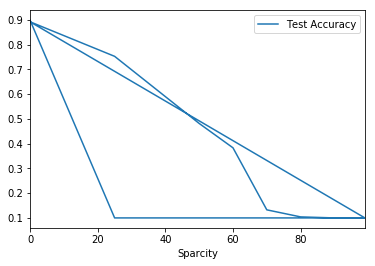

In [7]:
%matplotlib inline
df.plot(x="Sparcity", y="Test Accuracy", kind='line')

In [8]:
df

,Sparcity,Unit or Weight Pruned,Test Loss,Test Accuracy
0,0,Weight,0.912604,0.8980
1,25,Weight,14.506286,0.1000
2,50,Weight,14.506286,0.1000
3,60,Weight,14.506286,0.1000
4,70,Weight,14.506286,0.1000
5,80,Weight,14.506286,0.1000
6,90,Weight,14.506286,0.1000
7,95,Weight,14.506286,0.1000
8,97,Weight,14.506286,0.1000
9,99,Weight,13.526168,0.1000
